In [4]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
import torch.onnx
import onnxruntime as ort
from openvino.runtime import Core
import numpy as np
import time

# =========================
# 1. 定义模型
# =========================
class SimpleNN(nn.Module):
    def __init__(self):
        super(SimpleNN, self).__init__()
        self.fc1 = nn.Linear(28*28, 128)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = x.view(-1, 28*28)  # 拉平
        x = self.relu(self.fc1(x))
        return self.fc2(x)

model = SimpleNN()

# =========================
# 2. 准备数据
# =========================
transform = transforms.Compose([transforms.ToTensor()])
train_loader = torch.utils.data.DataLoader(
    datasets.MNIST('./data', train=True, download=True, transform=transform),
    batch_size=64, shuffle=True
)

# =========================
# 3. 训练模型（快速 1 epoch）
# =========================
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

print("开始训练...")
model.train()
for epoch in range(1):  # 只跑1个epoch，演示用
    for batch_idx, (data, target) in enumerate(train_loader):
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
    print(f"Epoch {epoch+1}, Loss={loss.item():.4f}")

# 保存 PyTorch 模型
torch.save(model.state_dict(), "./model/mnist_model.pth")
print("✅ 模型训练完成并保存")

# =========================
# 4. 导出到 ONNX
# =========================
dummy_input = torch.randn(1, 1, 28, 28)
torch.onnx.export(model, dummy_input, "./model/mnist_model.onnx", 
                  input_names=["input"], output_names=["output"],
                  opset_version=11)
print("✅ 模型已导出为 ONNX")

# =========================
# 5. 使用 PyTorch 推理
# =========================
model.eval()
with torch.no_grad():
    test_input = torch.randn(1, 1, 28, 28)
    output = model(test_input)
    print("PyTorch 预测类别:", torch.argmax(output, dim=1).item())

# =========================
# 6. 使用 ONNX Runtime 推理
# =========================
ort_session = ort.InferenceSession("./model/mnist_model.onnx")
onnx_input = {ort_session.get_inputs()[0].name: test_input.numpy()}
onnx_output = ort_session.run(None, onnx_input)
print("ONNX Runtime 预测类别:", np.argmax(onnx_output[0]))

# =========================
# 7. 使用 OpenVINO 推理
# =========================
ie = Core()
model_ov = ie.read_model("./model/mnist_model.onnx")
compiled_model = ie.compile_model(model_ov, "CPU")

input_layer = compiled_model.input(0)
output_layer = compiled_model.output(0)

results = compiled_model([test_input.numpy()])[output_layer]
print("OpenVINO 预测类别:", np.argmax(results))


开始训练...
Epoch 1, Loss=0.1513
✅ 模型训练完成并保存
✅ 模型已导出为 ONNX
PyTorch 预测类别: 2
ONNX Runtime 预测类别: 2
OpenVINO 预测类别: 2


### 模型推理流程

真实标签: 7, 推理预测: 8
预测概率分布: [[0.09289699 0.10262363 0.09797445 0.08946408 0.0906686  0.10460521
  0.09533735 0.10426681 0.11117065 0.11099226]]


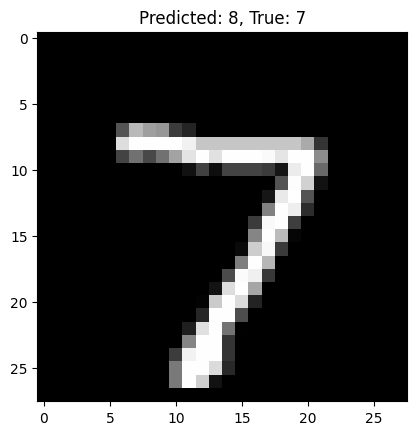

In [5]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt

# 1) 定义简单 CNN
class SimpleCNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 16, 3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(16, 32, 3, padding=1)
        self.fc1 = nn.Linear(32*7*7, 128)
        self.fc2 = nn.Linear(128, 10)  # 10 类数字

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 32*7*7)
        x = F.relu(self.fc1(x))
        return self.fc2(x)

# 2) 加载训练好的模型（此处假设已训练好）
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = SimpleCNN().to(device)
model.eval()

# 如果有训练好的权重，可加载：
# model.load_state_dict(torch.load("mnist_cnn.pth", map_location=device))

# 3) 准备测试样本
transform = transforms.Compose([transforms.ToTensor()])
testset = torchvision.datasets.MNIST(root="./data", train=False, download=True, transform=transform)

# 取一张样本做推理
img, label = testset[0]
input_tensor = img.unsqueeze(0).to(device)  # 增加 batch 维度

# 4) 模型推理
with torch.no_grad():
    logits = model(input_tensor)
    probs = torch.softmax(logits, dim=-1)
    pred_label = torch.argmax(probs, dim=-1).item()

# 5) 输出结果
print(f"真实标签: {label}, 推理预测: {pred_label}")
print(f"预测概率分布: {probs.cpu().numpy()}")

# 6) 可视化
plt.imshow(img.squeeze(), cmap='gray')
plt.title(f"Predicted: {pred_label}, True: {label}")
plt.show()
